BigARTM в целом похожа на тематическое моделирование в генсим, но немного посложнее (сложнее установить, сложнее обучать, сложнее использовать модель на новых данных). Сложность компенсируется скоростью (разница в порядках) и качеством моделей. 

Если хотите узнать по-подробнее про BigARTM, загуглите "BigARTM Воронцов" и кликайте любое видео.


### Установка BigARTM

Bigartm по-разному ставится для разных ОС. Инструкцию под вашу ОС можно найти тут - https://bigartm.readthedocs.io/en/stable/installation/index.html

Там можно пропустить установку питона и пипа.

(Если у вас не получается установить, попробуйте тетрадку для колаба или напишите мне)

In [52]:
# если вдруг еще не установлены
# !pip install pymorphy2[fast] nltk gensim

In [54]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
import string
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

In [55]:
nltk.download('punkt');nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/mnefedov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mnefedov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
stops = set(stopwords.words('russian'))


def opt_normalize(texts, top=None):
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    norm_uniq = {word:morph.parse(word.replace(':', ''))[0].normal_form for word, _ in uniq.most_common(top)}
    
    norm_texts = []
    for text in texts:
        
        norm_words = [norm_uniq.get(word) for word in text]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = [word.strip(string.punctuation) for word in text.split()]
    words = [word for word in words if word]
    
    return words

## Обучение модели


In [78]:
texts = open('wiki_data.txt').read().splitlines()
texts = opt_normalize([tokenize(text.lower()) for text in texts], 30000)

In [79]:
# вернемся сюда через какое-то время
# ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.3, 
#                            common_terms=set(stopwords.words('russian'))) # можно указать слова, которые 
                                                                          # не будут учитываться
# p = gensim.models.phrases.Phraser(ph)
# ngrammed_texts = p[texts]

In [80]:
# p[habr_texts[1]]

Для BigARTM требуется специальный формат данных. Их несколько, но мы возьмем vowpal wabbit.  
На каждой строчке файла находится одельный текст, записывается такст вот таким образом:  
```doc_name |@class_id word_1:1 word_2:3```  

|@class_id - задает модальность, но когда она одна её можно не указывать.

word_2:3 - слово и его частота (обратите внимание, что : - специальный символ и в словах его быть не может

In [81]:
f = open('wiki_texts.vw', 'w')

for i, text in enumerate(texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()



Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [82]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [83]:
batch_vectorizer = artm.BatchVectorizer(data_path='wiki_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [84]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [85]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [86]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=86833cbc-7b06-424e-aca3-470f5890f068, num_entries=11688)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [87]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [88]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [89]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [90]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

### Тренируем модель

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

In [91]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.002 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 759.551 (ARTM)


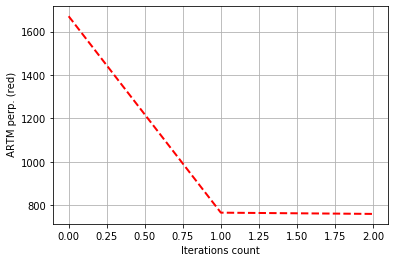

In [92]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [93]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [94]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [95]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.886 ARTM)
Sparsity Theta: 0.761 (ARTM)
Kernel contrast: 0.362 (ARTM)
Kernel purity: 0.527 (ARTM)
Perplexity: 237.531 (ARTM)


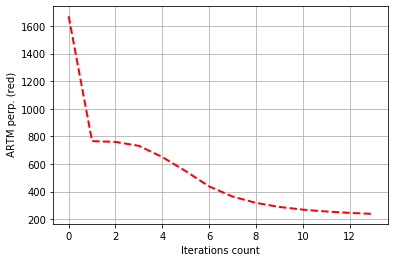

In [96]:
# посмотрим на качество
print_measures(model_artm)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась (в любом случае прогнать ещё парочку итераций не помешает). Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.


In [97]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
список
фамилия
представить
труд
различный
честь
происхождение
назвать
герой
социалистический
---------
topic_1: 
000
стадион
домашний
зритель
проводить
победа
арена
объявить
арен
футбольный
---------
topic_2: 
император
царь
хан
двор
империя
правление
династия
монета
сын
константин
---------
topic_3: 
научный
наука
факультет
профессор
кафедра
институт
доктор
университет
диссертация
защитить
---------
topic_4: 
армия
операция
войско
противник
наступление
командование
солдат
сила
немецкий
действие
---------
topic_5: 
академия
плата
советский
союз
лауреат
класс
«за
премия
народный
санкт-петербург
---------
topic_6: 
2016
2015
2019
2017
2020
2012
международный
2018
сотрудничество
2013
---------
topic_7: 
должность
пост
премьер-министр
отставка
фон
родиться
учитель
ложа
советник
посол
---------
topic_8: 
школа
училище
москва
театр
художественный
рсфср
метр
академический
российский
мастерский
---------
topic_9: 
современный
некоторый
оно
широкий
называть
состоять
стекло
считаться
о

# Домашнее задание


Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **